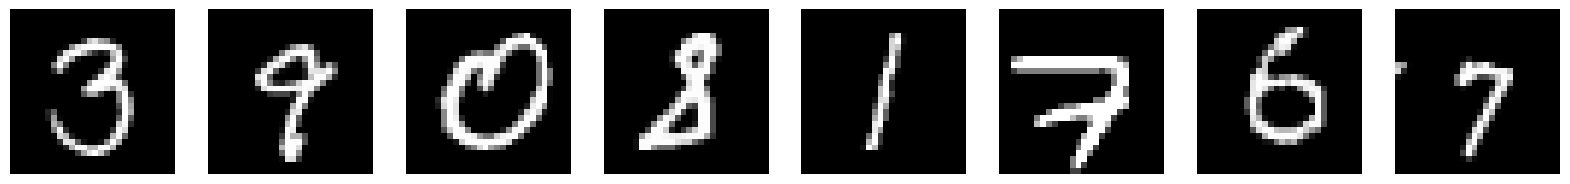

Epoch [1/1000], d_loss: 0.4414, g_loss: 2.3994, D(x): 0.84, D(G(z)): 0.21
Epoch [2/1000], d_loss: 0.1283, g_loss: 3.3066, D(x): 0.95, D(G(z)): 0.07
Epoch [3/1000], d_loss: 0.1230, g_loss: 4.0380, D(x): 0.94, D(G(z)): 0.05
Epoch [4/1000], d_loss: 0.7067, g_loss: 1.9452, D(x): 0.78, D(G(z)): 0.29
Epoch [5/1000], d_loss: 0.2590, g_loss: 3.3164, D(x): 0.88, D(G(z)): 0.05
Epoch [6/1000], d_loss: 0.7774, g_loss: 2.1802, D(x): 0.76, D(G(z)): 0.29
Epoch [7/1000], d_loss: 0.1832, g_loss: 3.4783, D(x): 0.92, D(G(z)): 0.07
Epoch [8/1000], d_loss: 0.8365, g_loss: 2.1988, D(x): 0.73, D(G(z)): 0.18
Epoch [9/1000], d_loss: 0.6976, g_loss: 1.7398, D(x): 0.81, D(G(z)): 0.32
Epoch [10/1000], d_loss: 0.6090, g_loss: 1.8656, D(x): 0.83, D(G(z)): 0.27
Epoch [11/1000], d_loss: 0.5350, g_loss: 2.2859, D(x): 0.84, D(G(z)): 0.23
Epoch [12/1000], d_loss: 0.3680, g_loss: 3.1321, D(x): 0.88, D(G(z)): 0.11
Epoch [13/1000], d_loss: 0.7069, g_loss: 2.2265, D(x): 0.82, D(G(z)): 0.19
Epoch [14/1000], d_loss: 0.8374, g

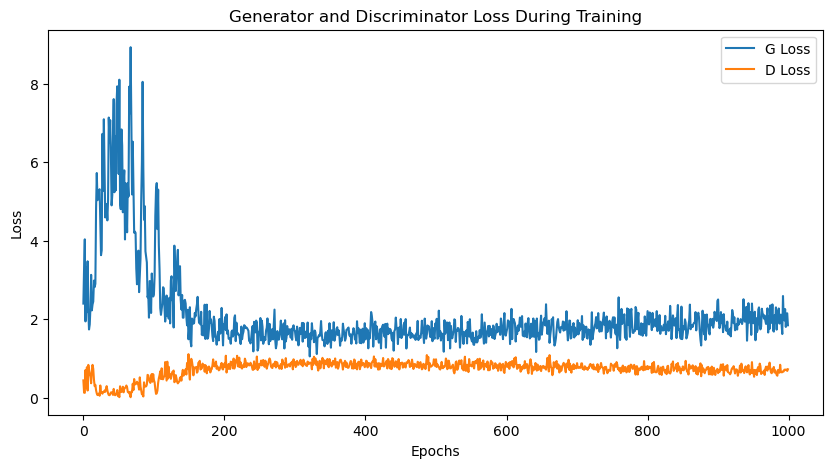

Generated samples have been saved.


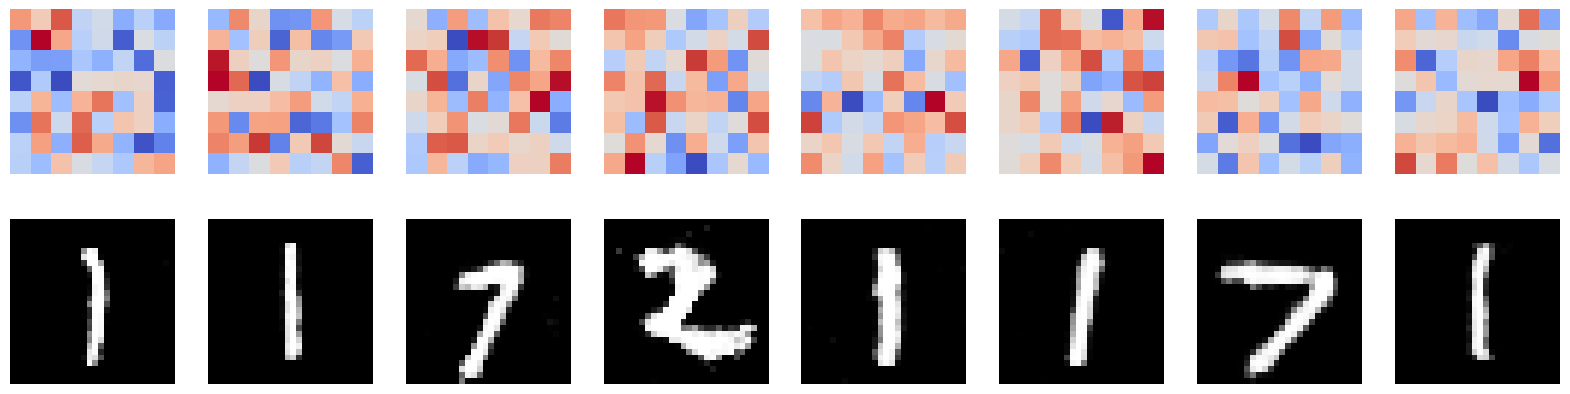

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyperparameters
latent_size = 64
hidden_size = 256
image_size = 784  # 28x28 flattened
num_epochs = 1000
batch_size = 128  # Increased batch size
learning_rate = 0.0001
num_workers = 12  # Number of workers for data loading

# MNIST dataset with transformations and data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# Display 8 examples from the dataset before training
data_iter = iter(data_loader)
images, _ = next(data_iter)
fig, axes = plt.subplots(1, 8, figsize=(20, 2.5)) 
for idx, img in enumerate(images[:8]):
    ax = axes[idx]
    # Normalized to [-1, 1]
    ax.imshow(img.squeeze(), cmap='gray', norm=plt.Normalize(-1,1))  
    ax.axis('off')
plt.show()

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
).to(device)

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(G.parameters(), lr=learning_rate)

# Function to create noise vector z
def noise(size):
    n = torch.randn(size, latent_size).to(device)
    return n

# Lists to keep track of progress
g_losses = []
d_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        current_batch_size = images.size(0)
        images = images.reshape(current_batch_size, image_size).to(device)
        
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        
        # Train Discriminator
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        z = noise(current_batch_size)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = noise(current_batch_size)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # Log the statistics at the end of each epoch
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, 
    g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, 
    D(G(z)): {fake_score.mean().item():.2f}')

# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G Loss")
plt.plot(d_losses, label="D Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate 8 examples to show noise and generated images
z = noise(8)  # Creating 8 examples
fake_images = G(z)
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
save_image(fake_images, 'generated_samples.png', nrow=4) 
print('Generated samples have been saved.')

# Visualize the noise vectors and their corresponding generated images
z = z.detach().cpu().view(8, 8, 8)  # Reshaping for visualization
fake_images = fake_images.detach().cpu()

fig, axes = plt.subplots(2, 8, figsize=(20, 5))
for idx in range(8):
    # Display noise vectors
    ax = axes[0, idx]
    ax.imshow(z[idx], cmap='coolwarm', interpolation='none')
    ax.axis('off')
    # Display generated images
    ax = axes[1, idx]
    ax.imshow(fake_images[idx].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()
